In [27]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv("demands.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [29]:
df['Overstock_Label'] = (df['Qty'] > 1.2 * df['Moving_Avg_Sales']).astype(int)

In [30]:
classification_features = ['Qty', 'Lead Time(days)', 'Moving_Avg_Sales', 'Cumulative_Sales', 'Lead_Time_Impact', 'Month', 'Week', 'Day_of_Week']
X = df[classification_features]
y = df['Overstock_Label']

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced'),
}

best_model = None
best_accuracy = 0
best_model_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

Random Forest Accuracy: 0.9805825242718447
Gradient Boosting Accuracy: 0.9805825242718447
Logistic Regression Accuracy: 0.7378640776699029


In [33]:
best_model_filename = f"best_{best_model_name.lower().replace(' ', '_')}_overstock_model.pkl"
joblib.dump(best_model, best_model_filename)
print(f"Best model saved: {best_model_filename}")

Best model saved: best_random_forest_overstock_model.pkl


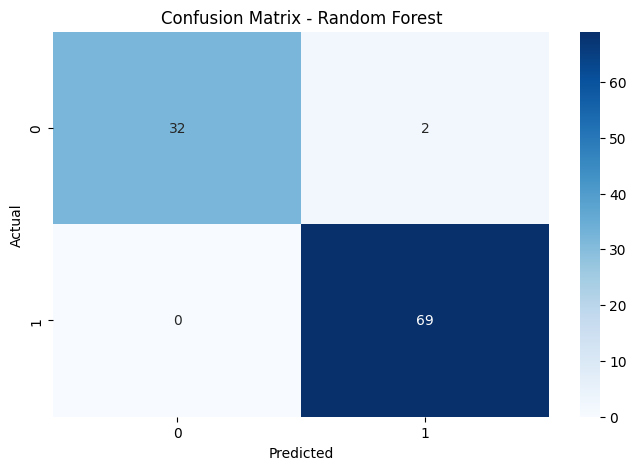

In [34]:
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

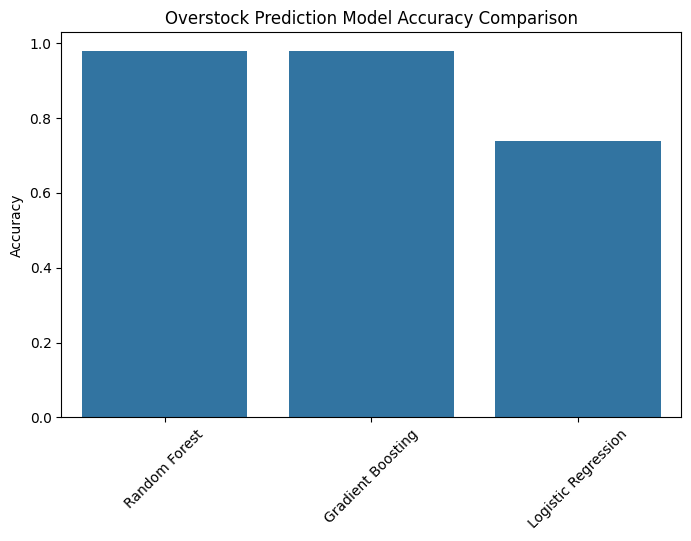

In [35]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(models.keys()), y=[accuracy_score(y_test, model.predict(X_test)) for model in models.values()])
plt.title("Overstock Prediction Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

In [36]:
print(f"Best Model: {best_model_name} - Accuracy: {best_accuracy}")
print("Classification Report:\n", classification_report(y_test, best_model.predict(X_test)))
print("Best model saved successfully!")

Best Model: Random Forest - Accuracy: 0.9805825242718447
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.97      1.00      0.99        69

    accuracy                           0.98       103
   macro avg       0.99      0.97      0.98       103
weighted avg       0.98      0.98      0.98       103

Best model saved successfully!


In [48]:
def predict_overstock(input_data, threshold=0.8):
    model = joblib.load(best_model_filename)
    input_df = pd.DataFrame([input_data], columns=classification_features)
    input_scaled = scaler.transform(input_df)
    prob = model.predict_proba(input_scaled)[:, 1]  # Probability of Overstock
    return "Overstock" if prob >= threshold else "No Overstock"

# Example Prediction
test_cases = [
    {"Qty": 50, "Lead Time(days)": 2, "Moving_Avg_Sales": 100, "Cumulative_Sales": 200, "Lead_Time_Impact": 1.0, "Month": 1, "Week": 5, "Day_of_Week": 1},  # No Overstock
    {"Qty": 1000, "Lead Time(days)": 30, "Moving_Avg_Sales": 50, "Cumulative_Sales": 500, "Lead_Time_Impact": 5.0, "Month": 12, "Week": 52, "Day_of_Week": 6}  # Overstock
]

for case in test_cases:
    print("Prediction:", predict_overstock(case))

Prediction: Overstock
Prediction: Overstock


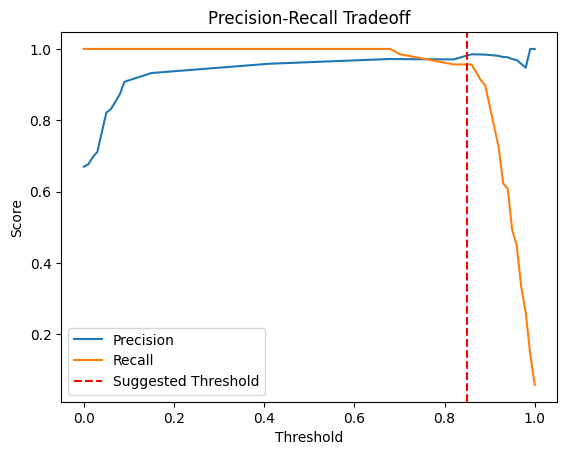

In [47]:
from sklearn.metrics import precision_recall_curve

y_scores = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision-Recall curve
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=0.85, color='r', linestyle='--', label="Suggested Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Tradeoff")
plt.show()
